# Simple HHL

This notebook demonstrates the simplest variant of HHL from Jack Morgan's code, with the swap test for measuring the fidelity of the solution.

* [Harrow, Hassidm, Lloyd](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.150502)
* [Lee, Joo, Lee](https://www.nature.com/articles/s41598-019-41324-9)
* [Morgan, Ghysels, Mohamadbagherpoor](https://arxiv.org/abs/2404.10103)
* [Jack Morgan's GitHub repository](https://github.com/jackhmorgan/Enhanced-Hybrid-HHL).

In [12]:
import numpy as np
from IPython.display import display, Markdown
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import ExactReciprocal, HamiltonianGate, PhaseEstimation, StatePreparation
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

In [14]:
def create_swap_test_circuit(num_state_qubits):
    num_qubits = 2 * num_state_qubits + 1
    result = QuantumCircuit(num_qubits)
    result.h(-1)
    for i in range(num_state_qubits):
        result.cswap(-1, i, num_state_qubits + i)
    result.h(-1)
    return result

def get_ideal_x_statevector(A, b):
    x = np.linalg.solve(A, b)
    x_norm = np.linalg.norm(x)
    x_state = x/x_norm
    return Statevector(x_state)

def create_circuit(λ):
    # Problem setup: λ is a parameter for the 2x2 problem; the eigenvalues are 1-λ and λ.
    A = np.array([[ 1/2 , λ-1/2],[λ-1/2,  1/2 ]])
    b = np.array([[1.], [0.]])

    # Parameters of HHL circuit:
    π = np.pi
    maxλ = 1
    num_clock_qubits = 3
    hamiltonian_scale = abs((0.5-2**-num_clock_qubits)/maxλ)
    inversion_scale = 2*2**-num_clock_qubits

    # Components of HHL circuit:
    state_preparation = StatePreparation(Statevector(b))
    hamiltonian_simulation = HamiltonianGate(A, -2 * π * hamiltonian_scale)
    qpe = PhaseEstimation(num_clock_qubits, hamiltonian_simulation)
    eigenvalue_inversion = ExactReciprocal(num_clock_qubits, inversion_scale, neg_vals=True)

    # Build circuit:
    flag = QuantumRegister(1)
    clock_reg = QuantumRegister(num_clock_qubits, "clock")
    b_reg = QuantumRegister(qpe.num_qubits - num_clock_qubits, "b")
    c_reg = ClassicalRegister(1, "c1")
    circuit = QuantumCircuit(flag, clock_reg, b_reg, c_reg)
    circuit.append(state_preparation, b_reg)
    circuit.append(qpe, clock_reg[:] + b_reg[:])
    circuit.append(eigenvalue_inversion, clock_reg[::-1]+[flag[0]])
    circuit.measure(0, 0)
    with circuit.if_test((0,1)) as passed:
        circuit.append(qpe.inverse(), clock_reg[:] + b_reg[:])
    num_b_qubits = int(np.log2(b.size))
    st_circuit = create_swap_test_circuit(num_b_qubits)
    q_reg = QuantumRegister(st_circuit.num_qubits - num_b_qubits, "q")
    c2_reg = ClassicalRegister(1, "c2")
    circuit.add_register(q_reg)
    circuit.add_register(c2_reg)
    ideal_x_statevector = get_ideal_x_statevector(A, b)
    with circuit.if_test((0,1)) as passed:
        circuit.prepare_state(ideal_x_statevector, q_reg[:-1])
        circuit.append(st_circuit, range(-st_circuit.num_qubits, 0))
        circuit.measure(-1, c2_reg[0])
    return circuit

# Circuit Diagram

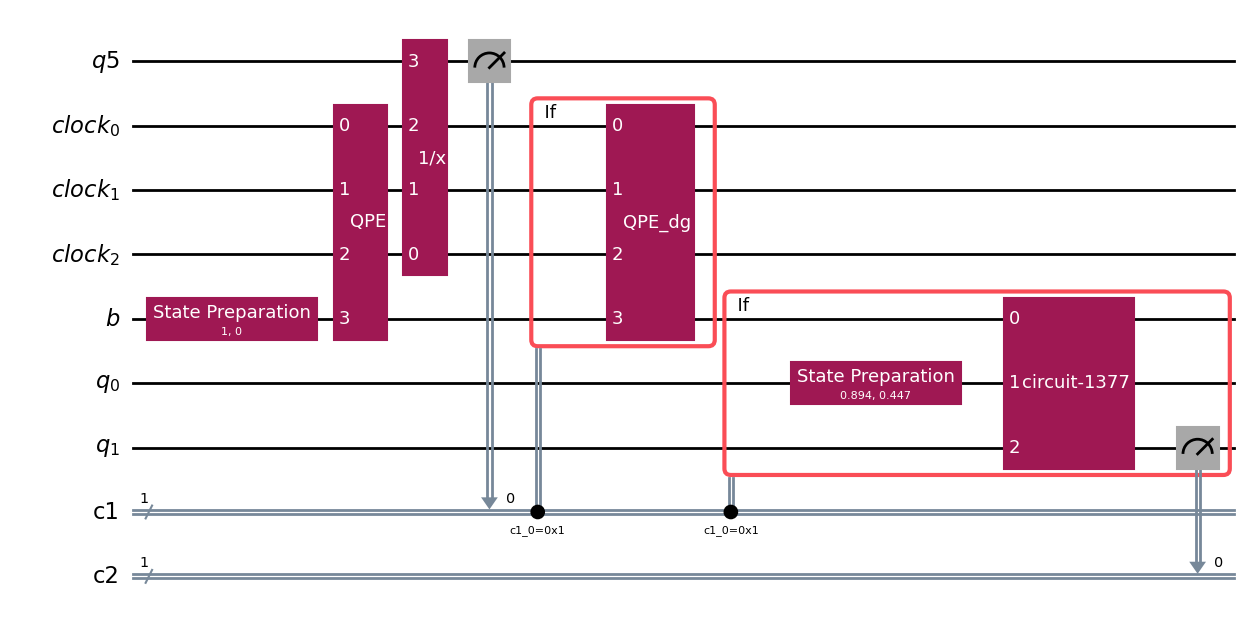

In [13]:
circuit = create_circuit(1/4)
display(Markdown("# Circuit Diagram"))
display(circuit.draw(output='mpl'))

# Fidelity as per Lee, Joo, Lee paper

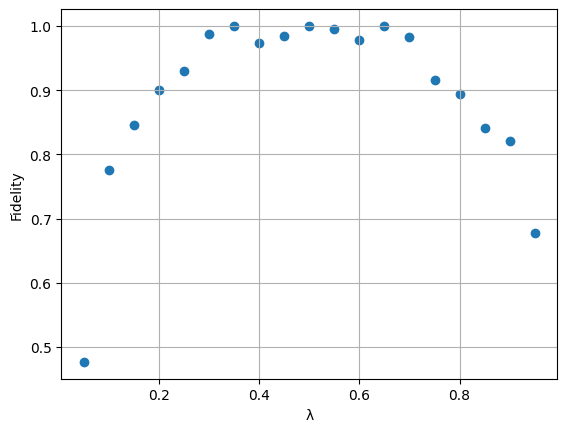

In [20]:
import matplotlib.pyplot as plt

def run_fidelity(λ):
    circuit = create_circuit(λ)
    backend = AerSimulator()
    transpiled_circuit = transpile(circuit, backend)
    job = backend.run(transpiled_circuit)
    counts = job.result().get_counts()
    count_01 = counts["0 1"] if "0 1" in counts else 0
    count_11 = counts["1 1"] if "1 1" in counts else 0
    prob_0 = count_01 / (count_01 + count_11)
    result = np.sqrt(2 * prob_0 - 1)
    return result

λ_values = [i/20 for i in range(1, 20)]
fidelity_values = [run_fidelity(λ) for λ in λ_values]

display(Markdown("# Fidelity as per Lee, Joo, Lee paper"))
plt.scatter(λ_values, fidelity_values)
plt.xlabel('λ')
plt.ylabel('Fidelity')
# plt.title('Fidelity vs λ')
plt.grid(True)
plt.show()